# Title
and Summary

### Load Data

notes

In [1]:
# !pip install utm # Ran once

In [4]:
%matplotlib inline
#%matplotlib qt # Choose %matplotlib qt to plot to an interactive window (note it may show up behind your browser)
# Make some of the relevant imports
import cv2 # OpenCV for perspective transform
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import scipy.misc # For saving images as needed
import glob  # For reading in a list of images from a folder
import imageio
import imageio.plugins.ffmpeg as ffmpeg

Load and process data (there's an error printed, but I think it might be fine)

In [5]:
#Loading the data and splitting it in testing and training data
from io import StringIO
import numpy as np
import csv
import math
import utm
import os

from sklearn.model_selection import train_test_split

# Cue up folders to check (MODIFY with addition or removal of folders)
data_folders = ['a1/','a2/','a3/','a4/','a5/','d1/','d2/','d3/','d4/','r3/','r4/','s1/']
# data_folders = ['r3/','r4/','s1/'] # type 1
# data_folders = ['a1/','a2/','a3/','d1/','d2/','d3/','d4/'] # type 2 (a,b,c,d)

odd_folders = ['r3/','r4/','s1/']

# Sets to be filled
labels = []
images = []

# Read and format each folder in cue
for folder in data_folders:

    # Load image filenames
    img_path = './data/' + folder
    img_filenames = os.listdir(img_path)

    # Load CSV data
    csv_path = img_path + "/im_info.csv"
    with open(csv_path, 'r') as x:
            # csv_data = list(csv.reader(x, delimiter=","))
            reader_obj = list(csv.reader(x, delimiter=","))
            data = []
            for row in reader_obj:
                data.append(row)
            csv_data = list(data)
                
    # Load data into np array and delete title row element
    csv_data = np.array(csv_data)
    csv_data = np.delete(csv_data,0,axis=0)
    
    # Begin formatting data
    print('Formatting Data for', folder ,'...')
    print('Number of datapoints:', len(csv_data))

    for i in range(0,len(csv_data)-2):
        # Load image
        image = img_path+img_filenames[i]
        if '.csv' in image: continue
        if '.ipynb_checkpoints' in image: continue
        
        # Load current data and data 1/3s into future (for next imgage)
        # Vals loaded from each line are [timestamp, yaw, lat, lon]
        curr_line = csv_data[i]
        curr_vals =  np.float_([curr_line[1],curr_line[4],curr_line[6],curr_line[7]])
        next_line = csv_data[i+1]
        next_vals =  np.float_([next_line[1],next_line[4],next_line[6],next_line[7]])
    
        curr_coord = utm.from_latlon(curr_vals[2], curr_vals[3])
        next_coord = utm.from_latlon(next_vals[2], next_vals[3])
    
        # time_change = next_vals[0] - curr_vals[0] # change in time
        time_change = 0.33 # approximately 3 datapoints taken per second. Could not to exact time change because of rounding
        angle_change = next_vals[1] - curr_vals[1] # change that should be commanded to current steering angle
        distance_change = abs(math.dist([curr_coord[0],curr_coord[1]],[next_coord[0],next_coord[1]]))
        velocity = distance_change/time_change # velocity that should be commanded
    
        label = [angle_change, velocity] # angle change is in degrees (I think), velocity units are __
    
        images.append(image)
        labels.append(label)


data_images = np.array(images)
data_labels = np.array(labels)

print('Formatting Complete')
print('=============================')

# Split data into training and testing sets
img_train, img_test, label_train, label_test = train_test_split(data_images, data_labels, test_size=0.2, random_state=42)

# Print the size of the resulting datasets
print(f"Training image data size: {len(img_train)}")
print(f"Testing image data size: {len(img_test)}")
print(f"Training label data size: {len(label_train)}")
print(f"Testing label data size: {len(label_test)}")


Formatting Data for a1/ ...
Number of datapoints: 115
Formatting Data for a2/ ...
Number of datapoints: 125
Formatting Data for a3/ ...
Number of datapoints: 132
Formatting Data for a4/ ...
Number of datapoints: 130
Formatting Data for a5/ ...
Number of datapoints: 132
Formatting Data for d1/ ...
Number of datapoints: 358
Formatting Data for d2/ ...
Number of datapoints: 419
Formatting Data for d3/ ...
Number of datapoints: 381


/tmp/ipykernel_5672/4087901193.py:40: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  csv_data = np.array(csv_data)


Formatting Data for d4/ ...
Number of datapoints: 443
Formatting Data for r3/ ...
Number of datapoints: 544
Formatting Data for r4/ ...
Number of datapoints: 524
Formatting Data for s1/ ...
Number of datapoints: 581
Formatting Complete
Training image data size: 3076
Testing image data size: 769
Training label data size: 3076
Testing label data size: 769


Load an image and check out labeling

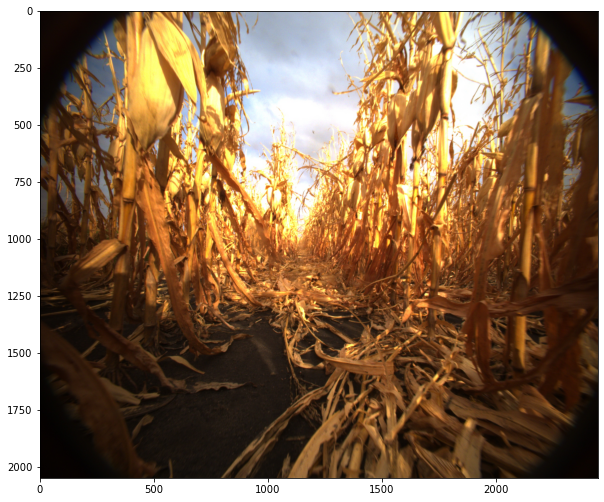

Steering Change to Make: 0.6296442000000013 | Velocity to Command: 1.1710425181800814


In [6]:
import random

# Select a random image from the list
img_rand = random.randint(0,len(img_train))

image = img_train[img_rand]

label = label_train[img_rand]

# Load the image using matplotlib
img = mpimg.imread(image)

# Display the image
plt.figure(figsize=(10,10))
plt.imshow(img)
plt.show()

# Print label
print('Steering Change to Make:',label[0], '| Velocity to Command:', label[1])

### Define CNNs for Training

As network models are developed for testing, put them in this area. Be sure class names are distinct and descriptive.

The below CNN was developed for HW3 Rover Problem

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

class MaizeRoverCNN_Simple(nn.Module):
    def __init__(self):
        super(MaizeRoverCNN_Simple, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 6) #in channels, out channels, kernel size, stride (opt.)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(739600, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = torch.flatten(x,1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x

This adds a third convolutional layer to the basic model used in HW3

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms


class MaizeRoverCNN_3Layer(nn.Module):
    def __init__(self):
        super(MaizeRoverCNN_3Layer, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 6) #in channels, out channels, kernel size, stride (opt.)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.conv3 = nn.Conv2d(16, 32, 4) # unused currently
        self.fc1 = nn.Linear(1438208, 360)
        self.fc2 = nn.Linear(360, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        # x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        
        x = torch.flatten(x,1) # flatten or view??
        
        x = F.relu(self.fc1(x)) # Change shape for fc layers
        x = F.relu(self.fc2(x))
        x = self.fc3(x)      
        return x


### Define Transforms

Test out various types of transforms on single images in this section.

**BASIC TRANSFORM (Resize, CenterCrop)**

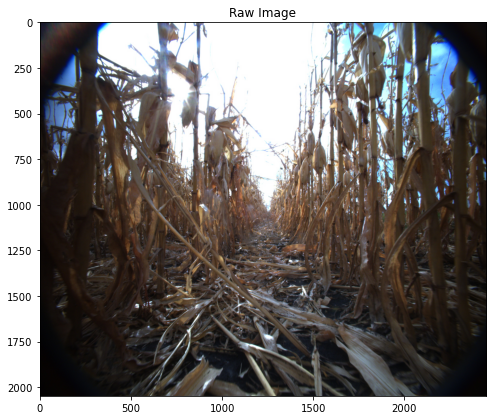

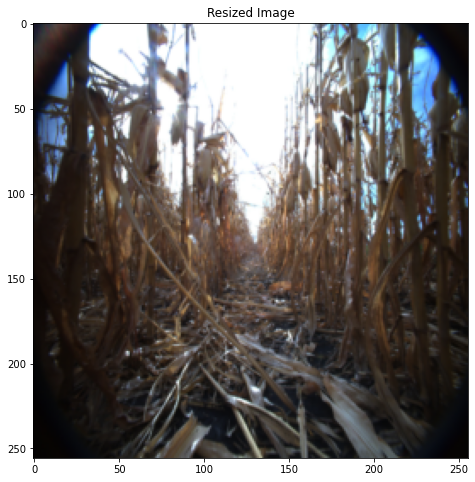

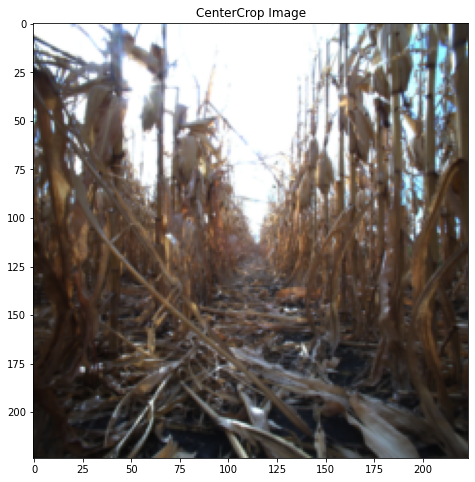

In [9]:
# BASIC TRANSFORM
import torch
import torchvision
from PIL import Image
# !pip install torchvision
from torchvision import datasets, transforms
# from torchvision import datapoints

# Select a random image from the list
img_rand = random.randint(0,len(img_train))
image_path = img_train[img_rand]

image = Image.open(image_path)

# Raw Image
fig = plt.figure(figsize=(8,8))
plt.imshow(image)
plt.title('Raw Image')
plt.show

# First Transform
transform=transforms.Compose([
            transforms.Resize((256,256))])

fig = plt.figure(figsize=(8,8))
plt.imshow(transform(image))
plt.title('Resized Image')
plt.show

# Second Transform
transform=transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224)])
            # transforms.ToTensor()])

fig = plt.figure(figsize=(8,8))
plt.imshow(transform(image))
plt.title('CenterCrop Image')
plt.show

#Full Basic transform, with tensor
transform_basic=transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor()]) 

**TRAPEZOIDAL CROP**

<function matplotlib.pyplot.show(close=None, block=None)>

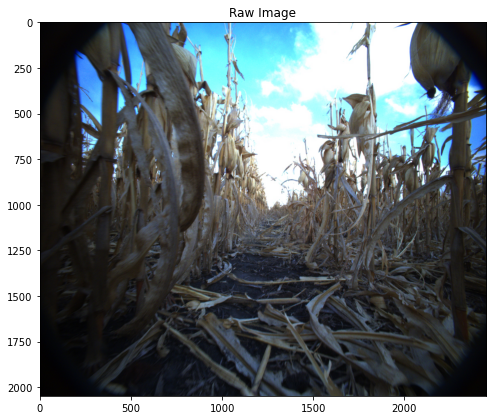

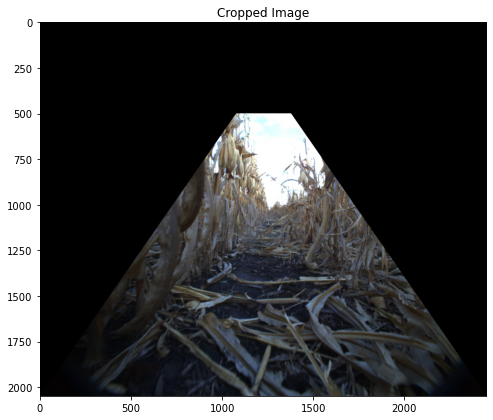

In [10]:
import torch
import torchvision
from PIL import Image, ImageDraw
import numpy as np
from torchvision import datasets, transforms

# Define the trapezoid shape crop
def trapezoid_crop(img, trap_height, trap_top_width, trap_bottom_width):
    width, height = img.size
    top_left = (width / 2 - trap_top_width / 2, trap_height)
    top_right = (width / 2 + trap_top_width / 2, trap_height)
    bottom_left = (0, height)
    bottom_right = (width, height)
    trap_points = [top_left, top_right, bottom_right, bottom_left]
    trap_mask = Image.new('L', (width, height), 0)
    ImageDraw.Draw(trap_mask).polygon(trap_points, outline=1, fill=1)
    img_arr = np.array(img)
    img_arr = np.array(img_arr * np.expand_dims(np.array(trap_mask), axis=-1), dtype=np.uint8)
    img_cropped = Image.fromarray(img_arr)
    return img_cropped

# Select a random image from the list
img_rand = random.randint(0,len(img_train))
image_path = img_train[img_rand]

image = Image.open(image_path)

# Raw Image
fig = plt.figure(figsize=(8,8))
plt.imshow(image)
plt.title('Raw Image')
plt.show

# Apply trapezoid crop
trap_height = 500
trap_top_width = 300
trap_bottom_width = 800

image = trapezoid_crop(image, trap_height, trap_top_width, trap_bottom_width)

fig = plt.figure(figsize=(8,8))
plt.imshow(image)
plt.title('Cropped Image')
plt.show

**FULL TRANSFORM**

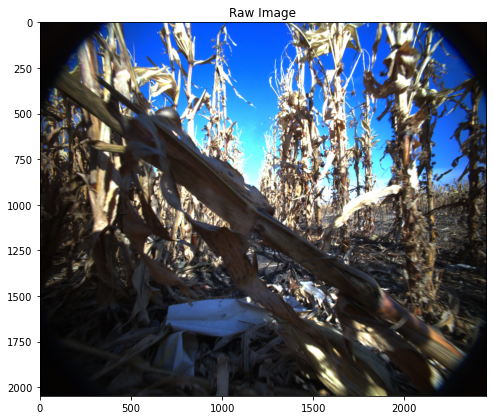

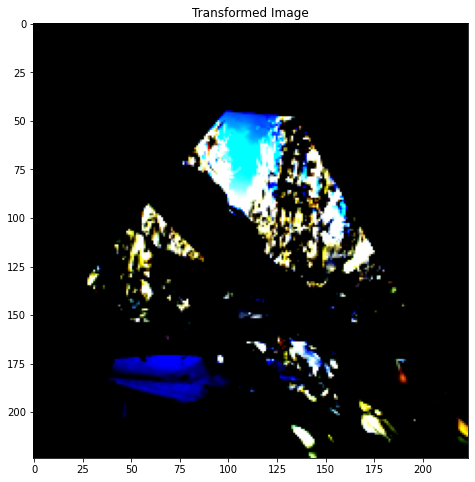

In [11]:
#Transformation (training the dataset by augmenting the dataset with more diverse images, making the models more robust to variations in the input data.)
#This code is used for image data augmentation,which helps in increasing the diversity of images in the dataset

# These transforms randomly rotate, flip horizontally and vertically, adjust brightness, contrast, saturation, hue, resize, center crop, convert to tensor, 
# and normalize the image pixel values.
transform_full = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Select a random image from the list
img_rand = random.randint(0,len(img_train))
image_path = img_train[img_rand]

image = Image.open(image_path)

# Raw Image
fig = plt.figure(figsize=(8,8))
plt.imshow(image)
plt.title('Raw Image')
plt.show

# Apply trapezoid crop
trap_height = 500
trap_top_width = 300
trap_bottom_width = 800

image = trapezoid_crop(image, trap_height, trap_top_width, trap_bottom_width)

# Apply the transforms
image = transform_full(image)
image = np.clip(image, 0, 1)

# Display the transformed image
fig = plt.figure(figsize=(8,8))
plt.imshow(np.transpose(image.numpy(), (1, 2, 0)))
plt.title('Transformed Image')
plt.show()


## Prepare Datasets, Load Data

In [12]:
# import torch
# from torch.utils.data import Dataset
# from torchvision import datasets, transforms
# from PIL import Image

# class MaizeRoverDataset(Dataset):
#     def __init__(self, images, labels, transform=None):
#         # Normalize labels between 0 and 1
#         temp_labels = labels
#         norm_labels = []
        
#         steer_max = 0
#         steer_min = 0
#         vel_max = 0
#         vel_min = 0
        
#         # Find min and max values for normalization
#         for lbl in temp_labels:
#             if lbl[0] > steer_max: steer_max = lbl[0]
#             if lbl[0] < steer_min: steer_min = lbl[0]
#             if lbl[1] > vel_max: vel_max = lbl[1]
#             if lbl[1] < vel_min: vel_min = lbl[1]
            
#         # Normalize all labels   
#         for lbl in temp_labels:
#             steer_norm = (lbl[0] - steer_min) / (steer_max - steer_min)
#             vel_norm = (lbl[1] - vel_min) / (vel_max - vel_min)
            
#             norm_labels.append([steer_norm, vel_norm])
        
#         self.labels = np.array(norm_labels)
#         self.images = images
#         self.transform = transform        
    
#     def __len__(self):
#         return len(self.images)
    
#     def __getitem__(self,idx):
#         img_path = self.images[idx] # './data/IMG_data/' + self.images[idx]
#         image = Image.open(img_path)
#         label = self.labels[idx]
        
#         if self.transform:
#             image = self.transform(image)
        
#         return image, label



Custom dataloader, including boolean value for performing trapezoidal crop

In [13]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets, transforms
from PIL import Image

class MaizeRoverDataset(Dataset):
    def __init__(self, images, labels, transform=None, trap=False):
        # Normalize labels between 0 and 1
        temp_labels = labels
        norm_labels = []
        
        steer_max = 0
        steer_min = 0
        vel_max = 0
        vel_min = 0
        
        # Find min and max values for normalization
        for lbl in temp_labels:
            if lbl[0] > steer_max: steer_max = lbl[0]
            if lbl[0] < steer_min: steer_min = lbl[0]
            if lbl[1] > vel_max: vel_max = lbl[1]
            if lbl[1] < vel_min: vel_min = lbl[1]
            
        # Normalize all labels   
        for lbl in temp_labels:
            steer_norm = (lbl[0] - steer_min) / (steer_max - steer_min)
            vel_norm = (lbl[1] - vel_min) / (vel_max - vel_min)
            
            norm_labels.append([steer_norm, vel_norm])
        
        self.labels = np.array(norm_labels)
        self.images = images
        self.transform = transform    
        self.trap = trap
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self,idx):
        img_path = self.images[idx] # './data/IMG_data/' + self.images[idx]
        image = Image.open(img_path)
        label = self.labels[idx]
        
        # Apply trapezoid crop
        if self.trap:
            image = trapezoid_crop(image, 500, 300, 800)
        
        if self.transform:
            image = self.transform(image)
        
        return image, label



Define training parameters to use

In [14]:
# PAREMETERS FOR MODEL TRAINING
BATCH_SIZE = 32
EPOCHS = 5

# TRAINING AND VALIDATION SPLIT
TRAIN_SPLIT = 0.75
VAL_SPLIT = 1 - TRAIN_SPLIT

#Define image transform used
transform = transform_basic # transform_full or transform_basic

Load data for training, validating, and testing models.

In [15]:
#Load Training and Testing Data
from torch.utils.data import DataLoader
from torch.utils.data import random_split
           
# load datasets
training_data = MaizeRoverDataset(img_train, label_train, transform, True)
test_data = MaizeRoverDataset(img_test, label_test, transform, True)

# do train/validation split
numTrainSamples = int(math.ceil(len(training_data) * TRAIN_SPLIT))
numValSamples = int(math.floor(len(training_data) * VAL_SPLIT))
print('TrainSamps:',numTrainSamples,'ValSamps:',numValSamples,
      'Total:', numTrainSamples+numValSamples)


(train_data, val_data) = random_split(training_data, 
                                    [numTrainSamples, numValSamples],
                                    generator=torch.Generator().manual_seed(42))

# New data loaders
train_loader =  DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader =  DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

# calculate steps per epoch for training and validation set
trainSteps = len(train_loader.dataset) // BATCH_SIZE
valSteps = len(val_loader.dataset) // BATCH_SIZE
testSteps = len(test_loader.dataset) // BATCH_SIZE

TrainSamps: 2307 ValSamps: 769 Total: 3076


#### BASIC TRAINING SETUP FROM HW3

In [14]:
import time

# initialize model and training parameters
model = MaizeRoverCNN_Simple()
lossFn = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9) #opt = Adam(model.parameters(), lr=INIT_LR)

# initialize model and training parameters - GAURAV from HW3
# model = MaizeRoverCNN_Simple()
# lossFn = nn.SmoothL1Loss()
# optimizer = optim.Adam(model.parameters(), lr = 0.0001, weight_decay=0.001)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5) 

# initialize a dictionary to store training history
H = {
	"train_loss": [],
	"val_loss": []
}

# measure how long training is going to take
print("====Training the network====")
startTime = time.time()

n_minibatches = len(train_loader)

# ------------------START TRAINING LOOP------------------
for epoch in range(0,EPOCHS):    
    # initialize the total training and validation loss
    totalTrainLoss = 0
    totalValLoss = 0
    
    running_loss = 0.0
    epoch_time = time.time()
    print_every = n_minibatches // 10
    # total_train_loss = 0
    
    print("EPOCH: {}/{}".format(epoch + 1, EPOCHS))
    print("==============================")
    
    # DO TRAINING
    # loop over training set
    for i, data in enumerate(train_loader):
        inputs, labels = data
        model.train()
        
        # perform forward pass and calculate training loss
        pred = model(inputs)
        loss = lossFn(pred, labels.float())
        
        # zero gradients, do backprop, update weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        
        # print every 10th of epoch
        if (i + 1) % (print_every + 1) == 0:    
            print("Epoch {}, {:d}% \t train_loss: {:.4f} took: {:.2f}s".format(
                epoch + 1, int(100 * (i + 1) / n_minibatches), running_loss / print_every,
                time.time() -epoch_time))
            running_loss = 0.0
            epoch_time = time.time()
        
        # add the loss to the total training loss so far
        totalTrainLoss += loss

        
    print('Training Step Done, Evaluating with Validation Data...')
    
    # EVALUATE WITH VALIDATION DATA
    # switch off autograd for evaluation
    with torch.no_grad():
        # set the model in evaluation mode
        model.eval()
        
        # loop over the validation set
        for data in val_loader:
            inputs, labels = data
            
            # make predictions and calculate the validation loss
            pred = model(inputs)
            totalValLoss += lossFn(pred, labels.float())
            
 
    # PRINT STATISTICS
    # calculate the average training and validation loss
    avgTrainLoss = totalTrainLoss / trainSteps
    avgValLoss = totalValLoss / valSteps
        
	# update our training history
    H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
    H["val_loss"].append(avgValLoss.cpu().detach().numpy())
    
	# print the model training and validation information
    print("Train loss: {:.6f}".format(avgTrainLoss))
    print("Val loss: {:.6f}\n".format(avgValLoss))

# ------------------END TRAINING LOOP------------------ 
    
# finish measuring how long training took
endTime = time.time()
print("====Training complete====")
print("Total time taken to train the model: {:.2f}s".format(endTime - startTime))

====Training the network====
EPOCH: 1/5
Epoch 1, 10% 	 train_loss: 0.2796 took: 47.07s
Epoch 1, 21% 	 train_loss: 0.1401 took: 47.53s
Epoch 1, 32% 	 train_loss: 0.0270 took: 47.34s
Epoch 1, 43% 	 train_loss: 0.0179 took: 46.42s
Epoch 1, 54% 	 train_loss: 0.0228 took: 46.74s
Epoch 1, 65% 	 train_loss: 0.0112 took: 47.08s
Epoch 1, 76% 	 train_loss: 0.0104 took: 47.00s
Epoch 1, 87% 	 train_loss: 0.0091 took: 46.88s
Epoch 1, 98% 	 train_loss: 0.0094 took: 46.38s
Training Step Done, Evaluating with Validation Data...
Train loss: 0.051334
Val loss: 0.009248

EPOCH: 2/5
Epoch 2, 10% 	 train_loss: 0.0118 took: 46.75s
Epoch 2, 21% 	 train_loss: 0.0119 took: 47.34s
Epoch 2, 32% 	 train_loss: 0.0087 took: 46.72s
Epoch 2, 43% 	 train_loss: 0.0097 took: 47.09s
Epoch 2, 54% 	 train_loss: 0.0116 took: 46.75s
Epoch 2, 65% 	 train_loss: 0.0110 took: 46.99s
Epoch 2, 76% 	 train_loss: 0.0107 took: 46.94s
Epoch 2, 87% 	 train_loss: 0.0087 took: 46.85s
Epoch 2, 98% 	 train_loss: 0.0106 took: 46.82s
Trainin

SAVE MODEL. **DEFINE NEW PATH NAME IF DIFFERENT MODEL WAS JUST TRAINED**

In [15]:
# Save entire model
# Specify a path
PATH = "trapBasicTransform_model.pt"

# Save
torch.save(model, PATH)

EVALUATE LOSS

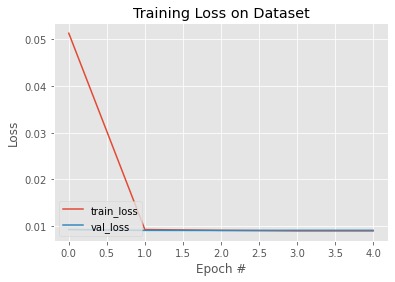

In [ ]:
# plot the training loss
plt.style.use("ggplot")
plt.figure()
plt.plot(H["train_loss"], label="train_loss")
plt.plot(H["val_loss"], label="val_loss")
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")

NOTE: PATH variable needs to have correct filename for whatever model we're testing

In [18]:
# ------------------RUN TEST DATA----------------------
import torch
import torchvision
from PIL import Image, ImageDraw
import numpy as np
from torchvision import datasets, transforms

totalTestLoss = 0

print("Running Test Dataset")

PATH = "trapBasicTransform_model.pt"
NUM_SAMPLES = 5

#Load saved model
model = torch.load(PATH)
torch.no_grad()
model.eval()
# Make sure these match what was used to train the model
lossFn = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9) #opt = Adam(model.parameters(), lr=INIT_LR)

# switch off autograd for evaluation
with torch.no_grad():
    # set the model in evaluation mode
    model.eval()
        
    # loop over the test set
    for data in test_loader:
        inputs, labels = data
            
        # make predictions and calculate the test loss
        pred = model(inputs)
        totalTestLoss += lossFn(pred, labels.float())
        
# calculate the average test loss
avgTestLoss = totalTestLoss / testSteps
        
# update our training history
    
# print the model training and validation information
print("Test loss (average): {:.6f}".format(avgTestLoss))

Running Test Dataset
Test loss (average): 0.026921


EVALUATE PERFORMANCE WITH SELECTED TEST IMAGES

NOTE: PATH variable needs to have correct filename for whatever model we're testing

Evaluating network with Testing Data...


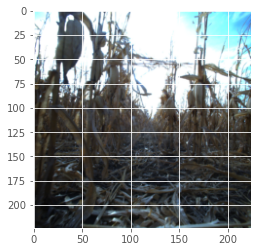

PREDICTED STEERING (de-normalized): 0.5107675790786743
ACTUAL STEERING (de-normalized):  0.4976772312378915
PREDICTED THROTTLE:  0.38257455825805664
ACTUAL THROTTLE:  0.7340733975534693


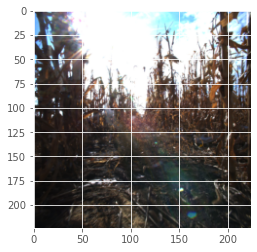

PREDICTED STEERING (de-normalized): 0.5072202086448669
ACTUAL STEERING (de-normalized):  0.4988701775602151
PREDICTED THROTTLE:  0.3801599144935608
ACTUAL THROTTLE:  0.496946698693043


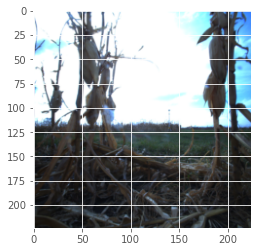

PREDICTED STEERING (de-normalized): 0.511829674243927
ACTUAL STEERING (de-normalized):  0.4985762895692547
PREDICTED THROTTLE:  0.38317835330963135
ACTUAL THROTTLE:  0.4825770061765689


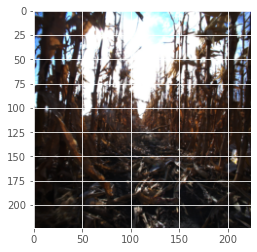

PREDICTED STEERING (de-normalized): 0.5036147236824036
ACTUAL STEERING (de-normalized):  0.49700680109277184
PREDICTED THROTTLE:  0.37712562084198
ACTUAL THROTTLE:  0.5561111758880162


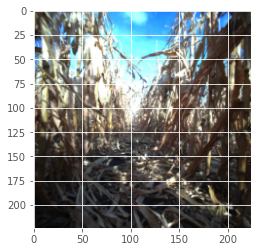

PREDICTED STEERING (de-normalized): 0.508325457572937
ACTUAL STEERING (de-normalized):  1.0
PREDICTED THROTTLE:  0.38057833909988403
ACTUAL THROTTLE:  0.5475876411462044
Evaluation Complete


In [17]:
import torch
import torchvision
from PIL import Image
# !pip install torchvision
from torchvision import datasets, transforms
# from torchvision import datapoints

print("Evaluating network with Testing Data...")

PATH = "trapBasicTransform_model.pt"
NUM_SAMPLES = 5

#Load saved model
model = torch.load(PATH)
torch.no_grad()
model.eval()

#Load Random Image
single_test_loader = DataLoader(test_data, batch_size=1, shuffle=True)

ct = 1;
for inputs, labels in single_test_loader:
    pred = model(inputs)
    
    img = np.transpose(inputs[0], (1, 2, 0))
    plt.imshow(img)
    plt.show()
    # print(labels)    

    print("PREDICTED STEERING (de-normalized):", pred[0,0].item())
    print("ACTUAL STEERING (de-normalized): ", labels[0,0].item())
    print("PREDICTED THROTTLE: ", pred[0,1].item())
    print("ACTUAL THROTTLE: ", labels[0,1].item())
    print("=============================")
    
    if ct == NUM_SAMPLES: break
    ct += 1
    
print("Evaluation Complete")